In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [5]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 22, 'n_layers': 2, 'dropout': 0.013875149619123436}


In [6]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [7]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU):
        super(SimpleNN, self).__init__()
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [8]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        1,489,664
│    └─Sequential: 2-1                   [1, 22]                   --
│    │    └─Linear: 3-1                  [1, 506]                  (500,940)
│    │    └─ReLU: 3-2                    [1, 506]                  --
│    │    └─Dropout: 3-3                 [1, 506]                  --
│    │    └─Linear: 3-4                  [1, 23]                   (11,661)
│    │    └─ReLU: 3-5                    [1, 23]                   --
│    │    └─Dropout: 3-6                 [1, 23]                   --
│    │    └─Linear: 3-7                  [1, 22]                   (528)
├─SimpleNN: 1-2                          [1, 1]                    --
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-8                  [1, 44]              

In [9]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [10]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     467.0550537109375     │
│         test_mse          │     467.0550537109375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 467.0550537109375, 'test_mse': 467.0550537109375}]

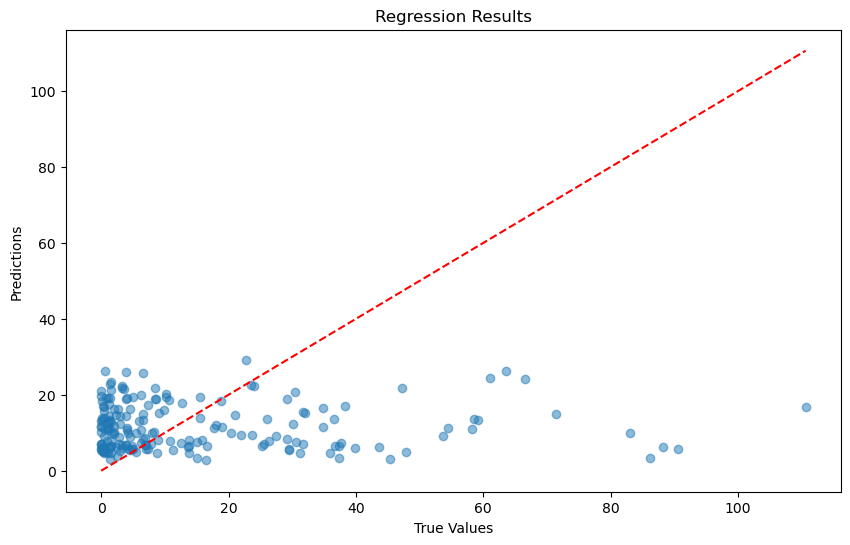

In [11]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [12]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [ ]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="ae_regressor_study")
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 12:13:52,133] A new study created in memory with name: ae_regressor_study


  0%|          | 0/100 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:14:41,995] Trial 0 finished with value: 1027.2843017578125 and parameters: {'n_layers': 15, 'dropout': 0.28269376397251755, 'learning_rate': 0.0023068827570659604, 'weight_decay': 0.0002338892803798945, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 0 with value: 1027.2843017578125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:16:18,969] Trial 1 finished with value: 676.1420288085938 and parameters: {'n_layers': 14, 'dropout': 0.2852498150333585, 'learning_rate': 0.0088037143782524, 'weight_decay': 0.00296677534277553, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:16:52,917] Trial 2 finished with value: 1048.2789306640625 and parameters: {'n_layers': 14, 'dropout': 0.1338194791881152, 'learning_rate': 0.0002152113585411131, 'weight_decay': 7.618780912303598e-05, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:17:43,909] Trial 3 finished with value: 1033.5028076171875 and parameters: {'n_layers': 6, 'dropout': 0.1705428239365238, 'learning_rate': 0.00014918222285909005, 'weight_decay': 0.0004090791519789148, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


In [ ]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

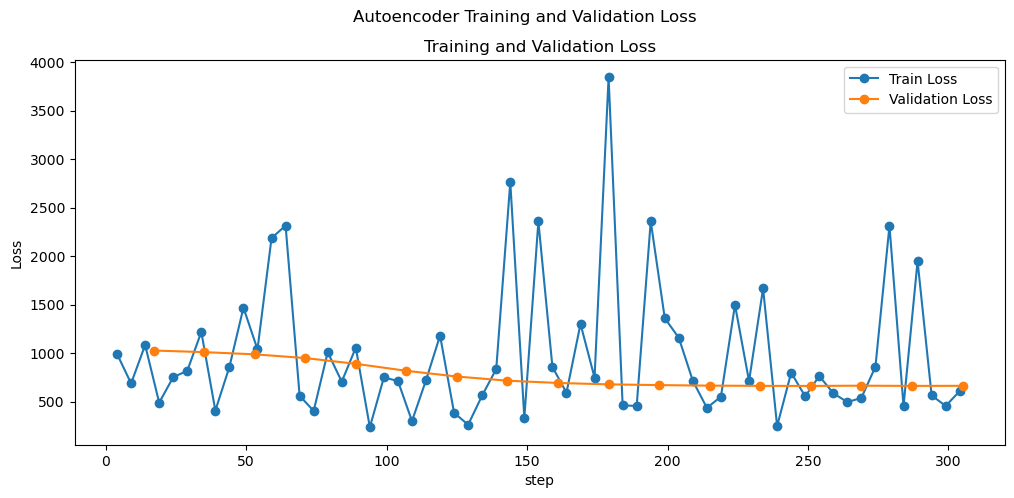

In [ ]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [ ]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/03/best_model.pth

In [ ]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}

best_model = BaseCancerRegressor.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    auto_encoder=CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        neural_network=SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=study.best_trial.params['n_layers'],
            dropout=study.best_trial.params['dropout'],
            activation=activation_dict[study.best_trial.params['activation']],
        ),
        lr=study.best_trial.params['learning_rate'],
        weight_decay=study.best_trial.params['weight_decay'],
        optimizer=optimizer_dict[study.best_trial.params['optimizer']],
    
)
best_model

BaseCancerRegressor(
  (auto_encoder): CancerDataAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=203, out_features=121, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.08362845598146633, inplace=False)
      (3): Linear(in_features=121, out_features=39, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.08362845598146633, inplace=False)
      (6): Linear(in_features=39, out_features=38, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=38, out_features=120, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.08362845598146633, inplace=False)
      (3): Linear(in_features=120, out_features=202, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.08362845598146633, inplace=False)
      (6): Linear(in_features=202, out_features=203, bias=True)
    )
    (loss_metric): MeanSquaredError()
    (val_metric): MeanSquaredError()
    (test_metric): MeanSquaredError()
  )
  (neural_network): SimpleNN(
    (network): Sequential(
      (0): Linear(

In [ ]:
joblib.dump(
    best_model,
    f"results/03/best_model_trial_ae_{study.best_trial.number}.pkl",
)

['results/03/best_model_trial_ae_84.pkl']

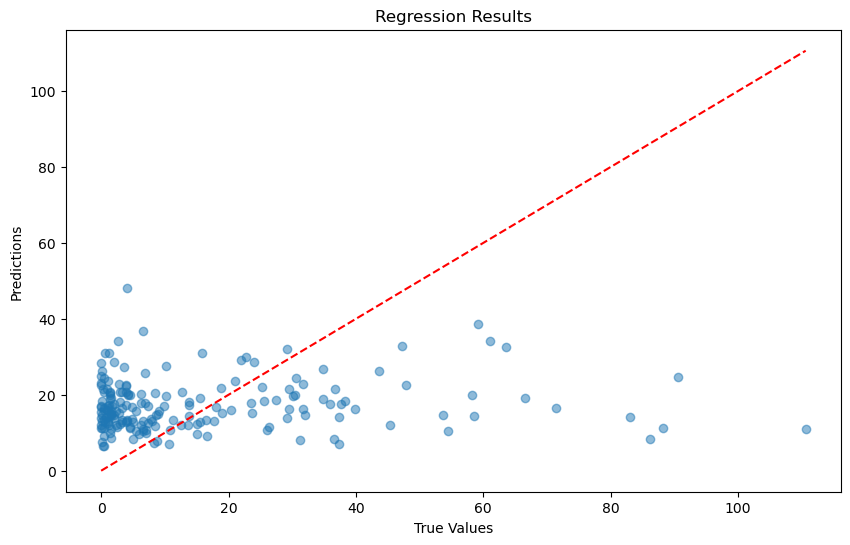

In [ ]:
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())